In [1]:
!pip install yfinance
!pip install factor_analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42622 sha256=7c4493b9fa7e170075b8173351c5b1bc798092917cabedf5fab517730777e421
  Stored in directory: /root/.cache/pip/wheels/fa/f7/53/a55a8a56668a6fe0199e0e02b6e0ae3007ec35cdf6e4c25df7
Successfully built factor_analyzer


In [2]:
try:
    import yfinance as yf
except ImportError:
    raise ImportError("Cannot start without 'yfinance' package.\nInstall it before running the code again.")

import bs4 as bs
import numpy as np
import os
import requests
from datetime import datetime
import pandas as pd
from pandas.core.frame import DataFrame
from scipy.sparse.linalg import eigsh
# from google.colab import drive
# drive.mount('/content/gdrive')



class SP500DataLoader:
    def __init__(self):
        if not os.path.exists('Data'):
            os.makedirs('Data')

        self.start_date, self.end_date = None, None
        self.cleaned_prices = None
        self.cleaned_returns = None
        self.raw_prices = None
        self.raw_returns = None

        # Download stocks names from S&P500 page on wikipedia
        resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
        soup = bs.BeautifulSoup(resp.text, 'lxml')
        table = soup.find('table', {'class': 'wikitable sortable'})
        self.tickers = []
        for row in table.findAll('tr')[1:]:
            ticker = row.findAll('td')[0].text
            self.tickers.append(ticker)
        self.tickers = [s.replace('\n', '') for s in self.tickers]
        self.tickers = self.tickers + ["SPY"]

    # Check whether 'start_date' and 'end_date' make a valid date range or not
    def check_date_range(self, start_date: tuple, end_date: tuple):
        start = datetime(*start_date)
        end = datetime(*end_date)

        if end <= start:
            raise Exception("The start date must be before the end date!")

        return start, end

    # Doanload prices using yfinance
    def download_prices(self, start_date, end_date, interval='1d', column='Adj Close'):
        self.start_date, self.end_date = self.check_date_range(start_date, end_date)
        self.raw_prices = yf.download(self.tickers, start=self.start_date, end=self.end_date, interval=interval)[column]

    # Helper function to write dataframes on files with specified names
    def write_on_disk(self, data: DataFrame, filename: str):
        if "csv" in filename:
            data.to_csv('Data/' + filename)
        elif "h5" in filename:
            data.to_hdf('Data/' + filename, 'fixed', mode='w', complib='blosc', complevel=9)

        print(f"Saved: Data/{filename}")

    # Return a list of stock names in S&P 500 index
    def get_stocks_list(self):
        return self.tickers.copy()

    # Return raw prices data (which is not cleaned)
    def get_raw_prices(self, start_date: tuple, end_date: tuple, interval='1d', column='Adj Close', save_as_h5=False, save_as_csv=False):
        self.download_prices(start_date, end_date)

        if save_as_csv:
            self.write_on_disk(self.raw_prices, "S&P500-raw_prices.csv")
        if save_as_h5:
            self.write_on_disk(self.raw_prices, "S&P500-raw_prices.h5")

        return self.raw_prices

    # Calculate and return raw returns data (which is not cleaned)
    def get_raw_returns(self, start_date: tuple, end_date: tuple, interval='1d', column='Adj Close', save_as_h5=False, save_as_csv=False):
        self.get_raw_prices(start_date, end_date)

        self.raw_returns = self.raw_prices.copy()
        self.raw_returns = np.log(self.raw_returns).diff()
        self.raw_returns = self.raw_returns.iloc[1:]  # removes first row which is NaN after diff()

        if save_as_csv:
            self.write_on_disk(self.raw_returns, "S&P500-raw_returns.csv")
        if save_as_h5:
            self.write_on_disk(self.raw_returns, "S&P500-raw_returns.h5")

        return self.raw_returns

    # Return cleaned prices data (stocks with at least on NAN value are excluded)
    def get_cleaned_prices(self, start_date: tuple, end_date: tuple, interval='1d', column='Adj Close', save_as_h5=False, save_as_csv=False):
        self.get_raw_prices(start_date, end_date)

        self.cleaned_prices = self.raw_prices.copy()
        # Remove companies (columns) with all missing values for whole time range
        self.cleaned_prices.dropna(axis='columns', how='all', inplace=True)
        # Remove days (rows) with missing values for all of companies
        self.cleaned_prices.dropna(axis='index', how='all', inplace=True)
        # Finally, remove the columns with at least one Nan (missing value)
        self.cleaned_prices.dropna(axis='columns', how='any', inplace=True)

        if save_as_csv:
            self.write_on_disk(self.self.cleaned_prices, "S&P500-cleaned_prices.csv")
        if save_as_h5:
            self.write_on_disk(self.self.cleaned_prices, "S&P500-cleaned_prices.h5")

        return self.cleaned_prices

    # Calculate return values using cleaned data, and return the dataframe
    def get_cleaned_returns(self, start_date: tuple, end_date: tuple, interval='1d', column='Adj Close', save_as_h5=False, save_as_csv=False):
        self.get_cleaned_prices(start_date, end_date)

        self.cleaned_returns = self.cleaned_prices.copy()
        self.cleaned_returns = np.log(self.cleaned_returns).diff()
        self.cleaned_returns = self.cleaned_returns.iloc[1:]  # removes first row which is NaN after diff()

        if save_as_csv:
            self.write_on_disk(self.cleaned_returns, "S&P500-cleaned_returns.csv")
        if save_as_h5:
            self.write_on_disk(self.cleaned_returns, "S&P500-cleaned_returns.h5")

        return self.cleaned_returns

    # Return the last values for raw prices without redownloading them
    def get_last_raw_prices(self, save_as_h5=False, save_as_csv=False):
        if self.raw_prices is None:
            return None

        if save_as_csv:
            self.write_on_disk(self.raw_prices, "S&P500-raw_prices.csv")
        if save_as_h5:
            self.write_on_disk(self.raw_prices, "S&P500-raw_prices.h5")

        return self.raw_prices

    # Return the last values for raw returns without redownloading them
    def get_last_raw_returns(self, save_as_h5=False, save_as_csv=False):
        if self.raw_returns is None:
            return None

        if save_as_csv:
            self.write_on_disk(self.raw_returns, "S&P500-raw_returns.csv")
        if save_as_h5:
            self.write_on_disk(self.raw_returns, "S&P500-raw_returns.h5")

        return self.raw_returns

    # Return the last values for cleaned prices without redownloading them
    def get_last_cleaned_prices(self, save_as_h5=False, save_as_csv=False):
        if self.cleaned_prices is None:
            return None

        if save_as_csv:
            self.write_on_disk(self.cleaned_prices, "S&P500-cleaned_prices.csv")
        if save_as_h5:
            self.write_on_disk(self.cleaned_prices, "S&P500-cleaned_prices.h5")

        return self.cleaned_prices

    # Return the last values for cleaned returns without redownloading them
    def get_last_cleaned_returns(self, save_as_h5=False, save_as_csv=False):
        if self.cleaned_returns is None:
            return None

        if save_as_csv:
            self.write_on_disk(self.cleaned_returns, "S&P500-cleaned_returns.csv")
        if save_as_h5:
            self.write_on_disk(self.cleaned_returns, "S&P500-cleaned_returns.h5")

        return self.cleaned_returns


**Collect S&P 500 stocks data, compute AvgCorr and FracVar**

In [3]:
# Upper tri masking
def upper_tri_masking(A):
    m = A.shape[0]
    r = np.arange(m)
    mask = r[:,None] < r
    return A[mask]

def diff_per(pc_fraction, avg_corr):
    return (pc_fraction - avg_corr) / ((pc_fraction + avg_corr) / 2)

def diff(pc_fraction, avg_corr):
    return pc_fraction - avg_corr

# Get cleaned S&P500 return values from 2000/05/19 to 2023/12/30
range_sp500 = range(2000, 2001)

# Initiate average correlation list, PC1 fraction list and delta^2 fraction list
corr_avg_list = []
pc1_fraction_list = []
delta_squared_fraction_list = []

for year in range_sp500:
    data_downloader_object = SP500DataLoader()
    cleaned_returns = data_downloader_object.get_cleaned_returns(
        start_date=(year, 1, 1), end_date=(year, 12, 31),
        interval='1d', column='Adj Close'
        )
    print('Year: ', year, '\n')

    cov = cleaned_returns.cov()
    corr = cleaned_returns.corr()
    n = cleaned_returns.shape[0]
    p = cleaned_returns.shape[1]

    # Calculate average of pair-wise correlations
    upper_tril_array = upper_tri_masking(corr.to_numpy())
    tril_avg = np.average(upper_tril_array)

    # Get the leading eigenvalue
    vals, vecs = eigsh(np.array(cov), p, which='LM')
    vals = vals[::-1]
    pc1 = vals[0]

    # Estimate delta squared and adjust fraction of PC1
    l_squared = (np.sum(vals) - pc1)/(n - 1)
    delta_squared = l_squared * (n/p)
    delta_squared_fraction = delta_squared/np.trace(cov)
    pc1_fraction = (pc1 - delta_squared)/np.trace(cov)

    # Store adjusted FracVar, FracDelta and AvgCorr
    pc1_fraction_list.append(pc1_fraction)
    delta_squared_fraction_list.append(delta_squared_fraction)
    corr_avg_list.append(tril_avg)

linear_df = pd.DataFrame({
    'PC1: Fraction of Variance Explained': pc1_fraction_list,
    # "Estimated Specific Variance": delta_squared_fraction_list,
    'Average Correlation': corr_avg_list,
    }, index=list(range_sp500))
print(linear_df)

IndexError: list index out of range

<Axes: >

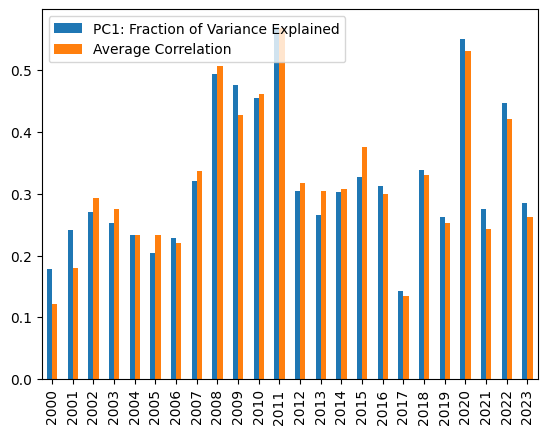

In [ ]:
linear_df.plot.bar()